In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jobathonfebruary2022/test_1zqHu22.csv
/kaggle/input/jobathonfebruary2022/sample_submission_JPlpRcN.csv
/kaggle/input/jobathonfebruary2022/train_0OECtn8.csv


In [2]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [3]:
!pip install pycaret

     |████████████████████████████████| 301 kB 596 kB/s            
     |████████████████████████████████| 25.9 MB 4.0 kB/s            
     |████████████████████████████████| 15.6 MB 60.0 MB/s            
     |████████████████████████████████| 24.2 MB 60.1 MB/s            
     |████████████████████████████████| 10.4 MB 60.4 MB/s            
     |████████████████████████████████| 114 kB 72.0 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 167 kB 66.8 MB/s            
     |████████████████████████████████| 636 kB 63.7 MB/s            
     |████████████████████████████████| 184 kB 52.2 MB/s            
     |████████████████████████████████| 1.0 MB 62.3 MB/s            
     |████████████████████████████████| 14.8 MB 37.7 MB/s            
     |████████████████████████████████| 58 kB 4.0 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 79 kB 6.1 MB/s             
  Created wh

In [4]:
#import modules
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [5]:
train = pd.read_csv('../input/jobathonfebruary2022/train_0OECtn8.csv')
test = pd.read_csv('../input/jobathonfebruary2022/test_1zqHu22.csv')
subm = pd.read_csv('../input/jobathonfebruary2022/sample_submission_JPlpRcN.csv')

In [6]:
print(train.shape)
print(test.shape)

(89197, 10)
(11121, 9)


In [7]:
def preproc(train,test):
    label_encoder = LabelEncoder()

    train['gender']= label_encoder.fit_transform(train['gender'])
    test['gender']= label_encoder.transform(test['gender'])
    
    #ordinal encoding of profession
    prof_map = {'Other':0,'Student':1,'Working Professional':2}
    train['profession'] = train['profession'].map(prof_map)
    test['profession'] = test['profession'].map(prof_map)

In [8]:
preproc(train,test)

In [9]:
targetcol = 'engagement_score'
target = train[targetcol]

In [10]:
exclude_cols =['row_id','user_id','video_id','category_id']
features =[col for col in train.columns if col not in exclude_cols]
print(len(features))
print(features)
features_excl_target = [col for col in features if col!=targetcol]

6
['age', 'gender', 'profession', 'followers', 'views', 'engagement_score']


In [11]:
# catcols = ['user_id','category_id','video_id','gender']
# catcols = ['category_id','video_id','gender']
catcols = ['gender']
numeric_cols = [col for col in features if col not in catcols+[targetcol]]
print(numeric_cols)

['age', 'profession', 'followers', 'views']


In [12]:
from pycaret.regression import *

In [13]:
s = setup(train[features], session_id=100,
          silent=True,
          numeric_features=numeric_cols,
          categorical_features=catcols,
#           high_cardinality_features=['user_id'],
#           high_cardinality_method='frequency',
          target = targetcol
#           preprocess=False,
#           use_gpu=True,
#           normalize=True,# normalize_method='minmax',
          )

,Description,Value
0,session_id,100
1,Target,engagement_score
2,Original Data,"(89197, 6)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(62437, 5)"


In [14]:
X_train = get_config('X_train')
print(len(X_train.columns))
X_train.columns

5


Index(['age', 'profession', 'followers', 'views', 'gender_0'], dtype='object')

In [15]:
%%time
# lgbm = create_model('lightgbm',early_stopping_rounds=100,eval_metric='auc',
#                     num_boost_round=1000)
lgbm = create_model('lightgbm')
lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5258,0.4979,0.7056,0.3614,0.1985,0.2475
1,0.5228,0.4776,0.6911,0.3526,0.1875,0.2446
2,0.5374,0.5162,0.7185,0.3305,0.1979,0.2978
3,0.5215,0.4767,0.6905,0.3544,0.1879,0.2274
4,0.5267,0.4907,0.7005,0.3528,0.1923,0.2071
5,0.5299,0.4923,0.7016,0.3397,0.1898,0.2337
6,0.5192,0.4719,0.6869,0.3538,0.1844,0.2004
7,0.5341,0.4977,0.7055,0.3386,0.1926,0.2440
8,0.5170,0.4633,0.6806,0.3600,0.1826,0.2467
9,0.5251,0.4809,0.6935,0.3637,0.1905,0.2701


CPU times: user 1.37 s, sys: 123 ms, total: 1.49 s
Wall time: 8.55 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
%%time
# predict_model(lgbm)
final_model = finalize_model(lgbm)
test_preds = predict_model(final_model, data=test)
print(test_preds.head())

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0   89198     7986           12        42   14       1           1        180   
1   89199    11278           34       115   14       1           1        230   
2   89200    17245            8       110   44       0           2        280   
3   89201     9851           16       137   18       1           1        270   
4   89202    16008           34        96   47       0           0        230   

   views     Label  
0    138  4.092684  
1    840  3.758773  
2    628  2.685152  
3    462  3.891776  
4    840  2.181195  
CPU times: user 1.93 s, sys: 27.1 ms, total: 1.95 s
Wall time: 3.31 s


In [17]:
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

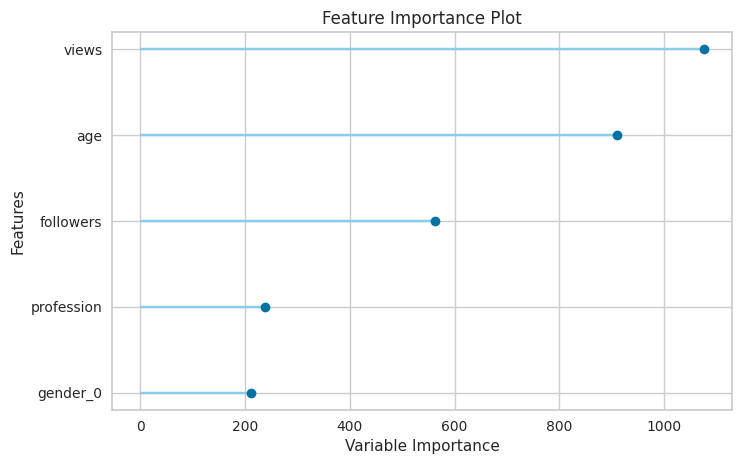

In [18]:
plot_model(lgbm,'feature')

In [19]:
submission = test_preds[['row_id','Label']]
submission=submission.rename(columns={'Label':'engagement_score'})
submission[['row_id','engagement_score']].to_csv('submission.csv',index=False)

In [20]:
test_sub = pd.read_csv('submission.csv')

In [21]:
print(test_sub.shape)
test_sub.head()

(11121, 2)


,row_id,engagement_score
0,89198,4.092684
1,89199,3.758773
2,89200,2.685152
3,89201,3.891776
4,89202,2.181195


In [22]:
test['category_id'].unique()

array([12, 34,  8, 16, 42,  5, 21, 19,  4, 25,  9, 15, 13, 11,  7,  1, 31,
       32, 10, 29, 18, 46, 44])

In [23]:
print(test['views'].describe())
print(train['views'].describe())

count    11121.000000
mean       454.959986
std        249.759038
min         44.000000
25%        229.000000
50%        369.000000
75%        662.000000
max        990.000000
Name: views, dtype: float64
count    89197.000000
mean       502.980268
std        268.569482
min         30.000000
25%        229.000000
50%        467.000000
75%        714.000000
max       1000.000000
Name: views, dtype: float64
